In [1]:
!pip install efficientnet -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import os

import cv2
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.svm import SVC


import tensorflow as tf

import efficientnet.keras as efn

import warnings
warnings.filterwarnings('ignore')

In [3]:
TRAIN_NORMAL_DIR = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
TRAIN_PNEUMONIA_DIR = '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
VAL_NORMAL_DIR = '../input/chest-xray-pneumonia/chest_xray/val/NORMAL'
VAL_PNEUMONIA_DIR = '../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
TEST_NORMAL_DIR = '../input/chest-xray-pneumonia/chest_xray/test/NORMAL'
TEST_PNEUMONIA_DIR = '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

In [4]:
train_normal_paths = []
train_pneumonia_paths = []

val_normal_paths = []
val_pneumonia_paths = []

test_normal_paths = []
test_pneumonia_paths = []

for dirname, _, filenames in os.walk(TRAIN_NORMAL_DIR):
    for filename in filenames:
        train_normal_paths.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(TRAIN_PNEUMONIA_DIR):
    for filename in filenames:
        train_pneumonia_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(VAL_NORMAL_DIR):
    for filename in filenames:
        val_normal_paths.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(VAL_PNEUMONIA_DIR):
    for filename in filenames:
        val_pneumonia_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(TEST_NORMAL_DIR):
    for filename in filenames:
        test_normal_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(TEST_PNEUMONIA_DIR):
    for filename in filenames:
        test_pneumonia_paths.append(os.path.join(dirname, filename))

In [5]:
train_normal_labels = ['Normal']*len(train_normal_paths)
train_pneumonia_labels = [c.split('/')[-1].split('.')[0].split('_')[1] for c in train_pneumonia_paths]

val_normal_labels = ['Normal']*len(val_normal_paths)
val_pneumonia_labels = [c.split('/')[-1].split('.')[0].split('_')[1] for c in val_pneumonia_paths]

test_normal_labels = ['Normal']*len(test_normal_paths)
test_pneumonia_labels = [c.split('/')[-1].split('.')[0].split('_')[1] for c in test_pneumonia_paths]

In [6]:
train = pd.DataFrame({'Paths': train_normal_paths+train_pneumonia_paths, 'Labels': train_normal_labels+train_pneumonia_labels})
val = pd.DataFrame({'Paths': val_normal_paths+val_pneumonia_paths, 'Labels': val_normal_labels+val_pneumonia_labels})
test = pd.DataFrame({'Paths': test_normal_paths+test_pneumonia_paths, 'Labels': test_normal_labels+test_pneumonia_labels})

In [7]:
train = shuffle(train.append(val), random_state=42)
test = shuffle(test, random_state=42)

In [8]:
IMG_SIZE = 128
EPOCHS = 30
FOLDS = 3
NAMES = ['EfficientNetB0', 'EfficientNetB1', 'ResNet50V2', 'VGG19']

In [9]:
train_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.4,
    height_shift_range=0.4, 
    shear_range=0.4,
    zoom_range=0.4,
    fill_mode='nearest', 
    horizontal_flip=True,
    vertical_flip=True, 
    rescale=1./255
)

val_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

testgen = test_generator.flow_from_dataframe(
    dataframe=test,
    target_size=(IMG_SIZE, IMG_SIZE),
    x_col='Paths',
    y_col='Labels',
    class_mode='categorical',
    shuffle=False,
)

Found 624 validated image filenames belonging to 3 classes.


In [10]:
def build_model(Model, input_shape=(IMG_SIZE, IMG_SIZE, 3), n_labels=3):
    model = tf.keras.models.Sequential()
    model.add(Model(input_shape=input_shape, weights='imagenet', include_top=False))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()]
    )
    return model

In [11]:
LR_START = 0.0001
LR_MAX = 0.00005 * 8
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True)

In [12]:
MODELS=[
    efn.EfficientNetB0,
    efn.EfficientNetB1,
    tf.keras.applications.ResNet50V2,
    tf.keras.applications.VGG19
]

In [13]:
valid_preds = pd.DataFrame()

trained_models = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

auc = {}

for MODEL in MODELS:
    
    name = str(MODEL).split(' ')[1]
    valid_preds[name] = np.zeros(len(train))
    valid_preds['True'] = np.zeros(len(train))   
    auc[name] = []
    
    print(f'Training {name}')
    for idx, (train_idx, valid_idx) in enumerate(skf.split(train['Paths'], train['Labels'])):
        print(f'## Fold: {idx} ##', '\n')

        train_paths, valid_paths = train['Paths'].iloc[train_idx], train['Paths'].iloc[valid_idx]
        train_labels, valid_labels = train['Labels'].iloc[train_idx], train['Labels'].iloc[valid_idx]

        train_per_fold = pd.DataFrame({'Paths': train_paths, 'Labels': train_labels})    
        valid_per_fold = pd.DataFrame({'Paths': valid_paths, 'Labels': valid_labels})

        traingen = train_generator.flow_from_dataframe(
            dataframe=train_per_fold,
            target_size=(IMG_SIZE, IMG_SIZE),
            x_col='Paths',
            y_col='Labels',
            class_mode='categorical',
            shuffle=True,
            seed=42
        )

        validgen = val_generator.flow_from_dataframe(
            dataframe=valid_per_fold,
            target_size=(IMG_SIZE, IMG_SIZE),
            x_col='Paths',
            y_col='Labels',
            class_mode='categorical',
            shuffle=False
        )
    
        model = build_model(Model=MODEL)
        model.fit_generator(
            traingen,
            epochs=EPOCHS,
            validation_data=(validgen),
            callbacks=[es, lr_callback],
        )
        
        y_pred = model.predict_generator(validgen)
        
        auc[name].append(metrics.roc_auc_score(validgen.labels, y_pred, multi_class='ovo'))
        
        valid_preds['True'].iloc[valid_idx] = validgen.labels
        valid_preds[name].iloc[valid_idx] = np.argmax(y_pred, axis=1)
        
        trained_models.append(model)

Training EfficientNetB0
## Fold: 0 ## 

Found 3488 validated image filenames belonging to 3 classes.
Found 1744 validated image filenames belonging to 3 classes.
16809984/16804768 [==============================] - 1s 0us/step
Epoch 1/30
109/109 [==============================] - 107s 980ms/step - loss: 0.9017 - recall: 0.4404 - precision: 0.6925 - auc: 0.7939 - val_loss: 1.1382 - val_recall: 0.4788 - val_precision: 0.5258 - val_auc: 0.6956
Epoch 2/30
109/109 [==============================] - 63s 580ms/step - loss: 0.7645 - recall: 0.6425 - precision: 0.7591 - auc: 0.8785 - val_loss: 1.2657 - val_recall: 0.5172 - val_precision: 0.5520 - val_auc: 0.6994
Epoch 3/30
109/109 [==============================] - 63s 582ms/step - loss: 0.7382 - recall: 0.6692 - precision: 0.7660 - auc: 0.8915 - val_loss: 0.7315 - val_recall: 0.6737 - val_precision: 0.7630 - val_auc: 0.8918
Epoch 4/30
109/109 [==============================] - 63s 582ms/step - loss: 0.7251 - recall: 0.6866 - precision: 0.7701 

In [14]:
def mapping(y):
    '''
    Normal -> 0
    bacteria -> 1
    virus -> 2
    '''
    
    map_ = []
    for idx, i in enumerate(y):
        if i == 'Normal':
            map_.insert(idx, 0)
        elif i == 'bacteria':
            map_.insert(idx, 1)
        else:
            map_.insert(idx, 2)
            
    return np.array(map_)

In [15]:
test_preds = pd.DataFrame({'True': testgen.labels})

for i in range(len(NAMES)):
    preds = np.zeros(len(testgen.labels))
    for j in range(FOLDS*i, FOLDS*(i+1)):
        preds += (1/FOLDS)*np.argmax(trained_models[j].predict_generator(testgen), axis=1)
    test_preds[NAMES[i]] = np.round(preds)

In [16]:
## Stacking

svm = SVC(kernel='linear', random_state=42)
svm.fit(valid_preds.drop(columns='True').values, valid_preds['True'])

final_preds = svm.predict(test_preds.drop(columns='True').values)

In [17]:
## Classification Report

print('EfficientNetB0:', '\n', metrics.classification_report(testgen.labels, test_preds['EfficientNetB0']))
print('EfficientNetB1:', '\n', metrics.classification_report(testgen.labels, test_preds['EfficientNetB1']))
print('ResNet50V2:', '\n', metrics.classification_report(testgen.labels, test_preds['ResNet50V2']))
print('VGG19:', '\n', metrics.classification_report(testgen.labels, test_preds['VGG19']))

print('Ensemble:', '\n', metrics.classification_report(testgen.labels, final_preds))

EfficientNetB0: 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73       234
           1       0.68      0.97      0.80       242
           2       0.73      0.66      0.69       148

    accuracy                           0.75       624
   macro avg       0.79      0.74      0.74       624
weighted avg       0.80      0.75      0.75       624

EfficientNetB1: 
               precision    recall  f1-score   support

           0       0.95      0.71      0.81       234
           1       0.69      0.97      0.80       242
           2       0.84      0.61      0.71       148

    accuracy                           0.79       624
   macro avg       0.83      0.76      0.77       624
weighted avg       0.82      0.79      0.78       624

ResNet50V2: 
               precision    recall  f1-score   support

           0       0.97      0.71      0.82       234
           1       0.76      0.98      0.85       242
           2       0.77  

EfficientNetB0


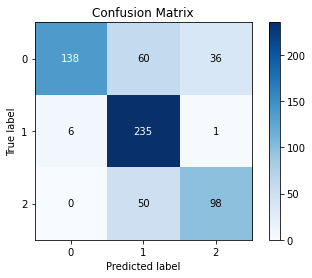

EfficientNetB1


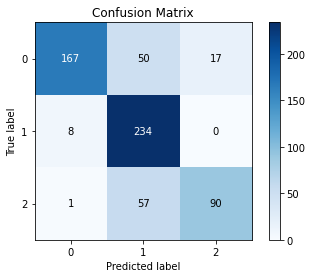

ResNet50V2


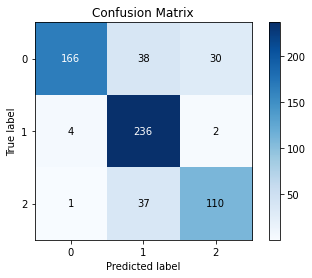

VGG19


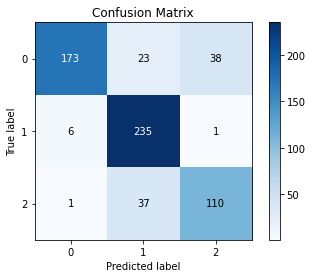

Ensemble


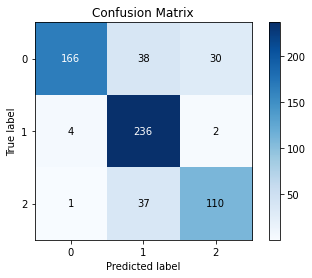

In [18]:
print('EfficientNetB0')
skplt.metrics.plot_confusion_matrix(
    test_preds['True'], 
    test_preds['EfficientNetB0'],
)
plt.show()

print('EfficientNetB1')
skplt.metrics.plot_confusion_matrix(
    test_preds['True'], 
    test_preds['EfficientNetB1'],
)
plt.show()

print('ResNet50V2')
skplt.metrics.plot_confusion_matrix(
    test_preds['True'], 
    test_preds['ResNet50V2'],
)
plt.show()

print('VGG19')
skplt.metrics.plot_confusion_matrix(
    test_preds['True'], 
    test_preds['VGG19'],
)
plt.show()

print('Ensemble')
skplt.metrics.plot_confusion_matrix(
    testgen.labels, 
    final_preds,
)
plt.show()